# Data Science and Visualization (RUC F2023)

## Miniproject Report

## Remarks:

1. This template serves as a guideline for structuring your miniproject report. You're supposed to follow the provided sections overall, but you're allowed to make changes or adjustments whenever it's appropriate for your particular project. 

    * For example, in each section provided below, you may use many cells instead of just one. 

    * You may also add subsections if you want. If necessary, you can also add or remove sections.


2. You should rename this notebook file to 'Group_xxx_report.ipynb' where 'xxx' is your group number in our [padlet] (https://padlet.com/luhua/dsv-f23-mini-project-group-formation-sgw8mxkajzhh0tli). This notebook should be submitted to Digital Exam in time.

3. Make sure the data you use is available somewhere and accessible to the examiner and censor. You may upload your data together with this report to Digital Exam, or put it online and provide the URL to it in this report. It's your own responsibility to ensure the data accessibility. 

4. Any text in '[ ]' throughout the template should be replaced by appropriate content that you're supposed to generate. Also remember to remove the pairs of '[' and ']' in the final report. 

5. Give sufficient descriptive and explanative information by using Markdown cells and/or comments in Python code.

6. Remove this cell in the final report.

7. If you have questions, please email to luhua@ruc.dk.

## Project Title: Energy consumption of algorithms and evaluation of data

## Group Members:
* [Mathias, computer science and informatics, 3rd, mamaar@ruc.dk]
* [Martin, computer science and informatics, 3rd, sundman@ruc.dk]


## Abstract

[Here, you need to write ~5 sentences to describe the main points of your project, including but not limited to, dataset, research questions, data science methods, findings from the data, your condlusions and remarks.]

The dataset is the result of an experiment measuring energy consumption of sorting algorithms. 
We are investigating how time complexity affects energy consumption of algorithms. 
We model the data using polynomial regression calculating the $R^2$ value to find the best fit.
Findings
Conclusion


## 0. Setup and Data

Import the modules needed for the project.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# QUESTIONS

-   what is feature selection (section 4.1)
-   how do we get the function describing the polynomial gotten from the regression (section 4.1)
-   memeory doesnt work (section 1)


### Data description:

[Here you should provide a description of your dataset and where to find the dataset.]

## 1. Loading the Data

[Below you should load the data, display a part of the data, show the shape (number of rows and that of columns) of the data, and show the statistics of the data.]

In [94]:
df = pd.read_csv("data/quickSort-PC27.csv") #dummy data
df.columns=["Test name","PKG (J)","CPU (J)","GPU (J)","Memory (J)","Temperature","Time (ms)"]

dfMemory = pd.read_csv("data/QuickSortMemory-PC#_Edit.csv") #What in the fuck 15249696.1 ? 

dfMemory = dfMemory.transpose()

dfMemory["Memory (byte)"] = dfMemory.index

dfMemory.reset_index()



,index,Memory (byte)
0,15247760,15247760
1,15249696,15249696
2,15249728,15249728
3,15249696.1,15249696.1
4,15247744,15247744
...,...,...
1234,132303432,132303432
1235,135453776,135453776
1236,133360640,133360640
1237,133356576,133356576


## 2. Data Preprocessing

[Below you should handle the missing values, convert data types, apply data scaling and so on, if any of them is needed.]

In [95]:
df["Memory (byte)"] = dfMemory["Memory (byte)"]
print("are they the same length? ", len(df) == len(dfMemory), f" len(df) = {len(df)}, len(dfMemory) = {len(dfMemory)}")

are they the same length?  True  len(df) = 1239, len(dfMemory) = 1239


In [96]:

#Missing at the moment
df["Memory (byte)"] = dfMemory["Memory (byte)"]

#removing values that are nonsense 
df = df[df['PKG (J)'] >= 0]
df = df[df['CPU (J)'] >= 0]
#df = df[df['Memory (byte)'] >= 0]
#df = df[df['Temperature'] >= 0]
df = df[df['Time (ms)'] >= 0]

df = df.replace("  ", np.nan)

#missing values for each column
print("MISSING DATA: \n\n ", df.isnull().sum(axis=0))

l = []
for i in range(len(df)):
    l.append(int(df.iloc[i]["Test name"].split("-")[1]))

df["Size"] = l


df

MISSING DATA: 

  Test name           0
PKG (J)             0
CPU (J)             0
GPU (J)          1239
Memory (J)          0
Temperature         0
Time (ms)           0
Memory (byte)    1239
dtype: int64


,Test name,PKG (J),CPU (J),GPU (J),Memory (J),Temperature,Time (ms),Memory (byte),Size
0,random1-25000-1,2.185303,1.924133,NaN,0.176636,32,224.060,NaN,25000
1,random1-25000-1,2.235840,1.966553,NaN,0.182495,32,229.134,NaN,25000
2,random1-25000-1,2.222351,1.958130,NaN,0.175842,32,228.631,NaN,25000
3,random2-25000-1,2.385925,2.082764,NaN,0.200623,32,230.392,NaN,25000
4,random2-25000-1,2.191040,1.913574,NaN,0.183411,32,241.332,NaN,25000
...,...,...,...,...,...,...,...,...,...
1234,best-1000000-1,8.129700,7.156677,NaN,0.616760,76,800.440,NaN,1000000
1235,best-1000000-1,8.162659,7.160950,NaN,0.626648,76,829.672,NaN,1000000
1236,best-1000000-1,8.048950,7.052307,NaN,0.628906,76,816.884,NaN,1000000
1237,best-1000000-1,7.960266,7.004578,NaN,0.609192,76,777.394,NaN,1000000


In [5]:
#random input seperated into a list, where each element is a DataFrame containing that random CSVs output
listOfRandoms = []
for randIndex in range(0,11):
    listOfRandoms.append(df[df["Test name"].str.startswith(f"random{randIndex}-")])


# Dataframe containing results for the best case input 
dfBest = df[df["Test name"].str.startswith("best")]
# Dataframe containing results for the worst case input 
dfWorst = df[df["Test name"].str.startswith("worst")]

In [6]:
dfWorst.head()

,Test name,PKG (J),CPU (J),GPU (J),Memory (J),Temperature,Time (ms),Size
519,worst-25000-1,6.182678,5.496948,NaN,0.384888,68,637.487,25000
520,worst-25000-1,5.975281,5.291138,NaN,0.375488,68,632.936,25000
521,worst-25000-1,6.040955,5.392456,NaN,0.369934,68,582.914,25000
522,worst-25000-1,5.984497,5.309143,NaN,0.371521,68,621.832,25000
523,worst-25000-1,6.250854,5.559387,NaN,0.375122,68,630.388,25000


In [7]:
listOfRandoms[2].head()

,Test name,PKG (J),CPU (J),GPU (J),Memory (J),Temperature,Time (ms),Size
3,random2-25000-1,2.385925,2.082764,NaN,0.200623,32,230.392,25000
4,random2-25000-1,2.191040,1.913574,NaN,0.183411,32,241.332,25000
5,random2-25000-1,2.369202,2.089172,NaN,0.198181,32,227.807,25000
6,random2-25000-1,2.248413,1.977356,NaN,0.182068,35,228.675,25000
43,random2-50000-1,2.717590,2.372864,NaN,0.218506,50,272.616,50000


## 3. Exploratory Data Analysis

[Below you can conduct EDA of your data, e.g., ask some questions and try to answer them by accessing the data properly and making some visualizations.]

First lets have a look at the data.

we do this by simply plotting some scatter plots.

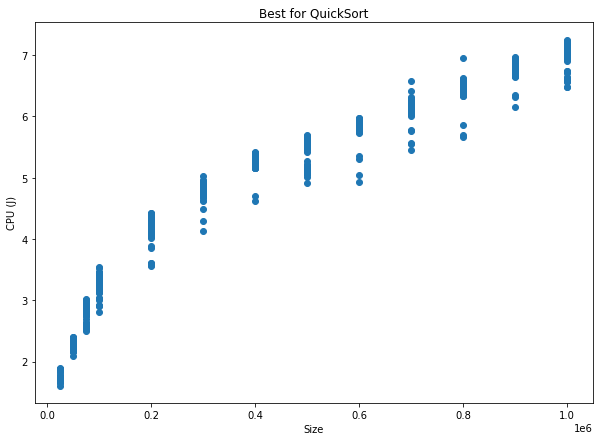

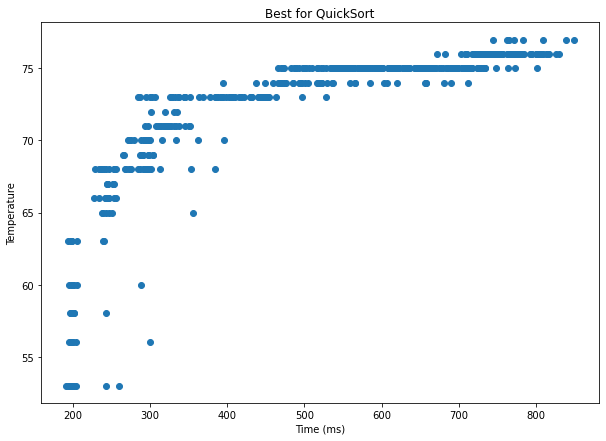

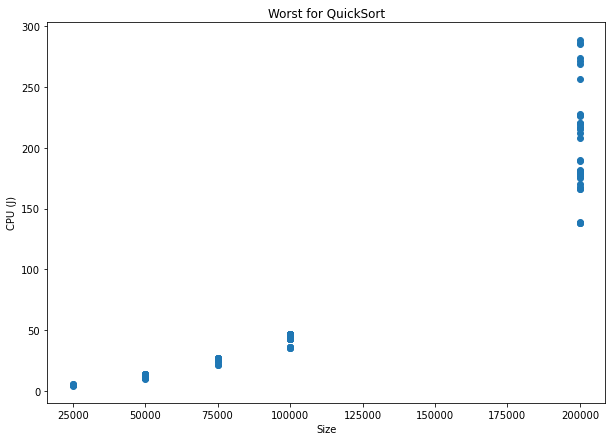

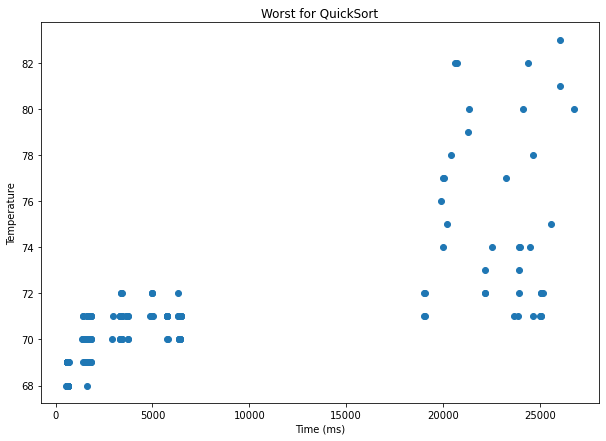

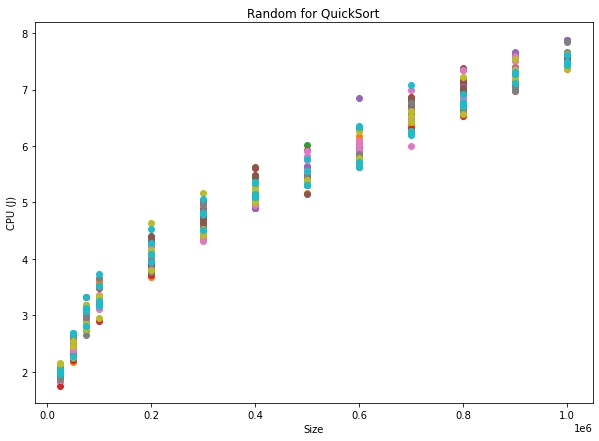

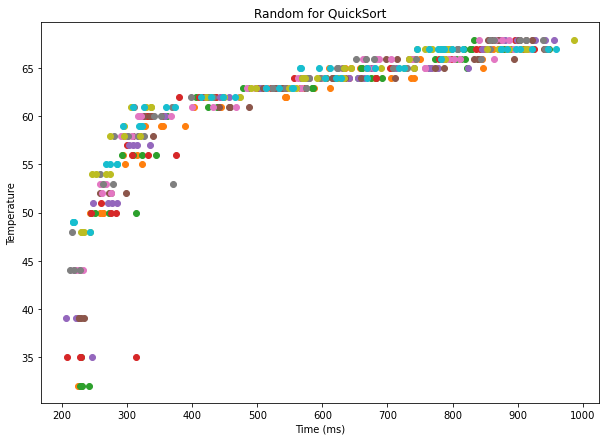

In [24]:
def plotWorst(strX,strY,dot="o"):
    plt.figure(figsize=(10, 7))
    x = dfBest[strX]
    y = dfBest[strY]
    plt.plot(x,y,dot, label="Best")
    plt.title("Best for QuickSort")
    plt.xlabel(strX)
    plt.ylabel(strY)
    plt.show()



def plotBest(strX,strY, dot = "o"):
    plt.figure(figsize=(10, 7))
    x = dfWorst[strX]
    y = dfWorst[strY]
    plt.plot(x,y,dot, label="Best")
    plt.title("Worst for QuickSort")
    plt.xlabel(strX)
    plt.ylabel(strY)
    plt.show()

def plotListOfRandoms(strX,strY,dot="o"):
    plt.figure(figsize=(10, 7))
    for i in range(10):
        plt.plot(listOfRandoms[i][strX],listOfRandoms[i][strY],dot, label=f"Random{i}")
    plt.title("Random for QuickSort")
    plt.xlabel(strX)
    plt.ylabel(strY)
    plt.show()

#plot data
plotWorst("Size", "CPU (J)")
#plotWorst("Size", "Memory (J)")
plotWorst("Time (ms)", "Temperature", dot='o')

plotBest("Size", "CPU (J)")
#plotBest("Size", "Memory (J)")
plotBest("Time (ms)", "Temperature", dot='o')

plotListOfRandoms("Size", "CPU (J)")
#plotListOfRandoms("Size", "Memory (J)")
plotListOfRandoms("Time (ms)", "Temperature", dot='o')



### Normal distribution
For each size we test if the data is normally distributed for that size

In [9]:
from scipy.stats import shapiro

for i in [25000,50000,75000,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000]:
    print(f"Size {i} from the best case input is normal distributed: {0.05 < shapiro(dfBest[dfBest['Size'] == i]['CPU (J)']).pvalue}")
    #plt.hist(dfBest[dfBest['Size'] == i]['CPU (J)'])
    #plt.show()


Size 25000 from the best case input is normal distributed: False
Size 50000 from the best case input is normal distributed: False
Size 75000 from the best case input is normal distributed: False
Size 100000 from the best case input is normal distributed: True
Size 200000 from the best case input is normal distributed: False
Size 300000 from the best case input is normal distributed: False
Size 400000 from the best case input is normal distributed: False
Size 500000 from the best case input is normal distributed: False
Size 600000 from the best case input is normal distributed: False
Size 700000 from the best case input is normal distributed: False
Size 800000 from the best case input is normal distributed: False
Size 900000 from the best case input is normal distributed: False
Size 1000000 from the best case input is normal distributed: False


According to the shapiro test if the returning pValue > 0.05 then the data is normal distrubuted and oppositely if pValue is < 0.05 then the data is not normal distributed. 

here we see that the data is not normal distributed.

## 4. Data Modelling

[Below you apply machine learning models and other data science methods to your data, e.g., classification, regression, clustering, and association rule mining. You should do at least one of them. Give a description of what you do here.]

### 4.1. Feature Selection

To compare energy, time and memory consumption of algorithms to eachother, we make a polynomial regression. 
When making a polynomial regression it is important to evaluate which degree the polynomial is at.

This can be done with metrics.r2_score(y, y_poly) on each degree. This will return a fitness value, in the form of a procentage represented as a float. Where 1.00 is 100% accuracy  


#### Structure of 4:
-   Best Time vs Size 
-   Worst Time vs Size
-   Random Time vs Size
    - Description of best degree for time
-   Best CPU energy consumption vs Size
-   Worst CPU energy consumption vs Size
-   Random CPU energy consumption vs Size
    - Description of best degree for CPU energy consumption


#### structure of 4
-   4.1 choose which parameters we use for the multiple 'models'
-   4.2 create loads of models (Poly, Liniear, DTR, Logit) and evaluate {R^2}
-   4.3 apply the model with the highest r2 value from 4.2 and use "extensive evaluation" to further judge if the model fits (what ever that means) 
-   4.4 plot the model


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

def polyReg(SeriesX, SeriesY,maxDegrees, Label, color, minDegrees = 2, plotLabel = True, printR2Score = True, plotGraph = True):
    X = SeriesX.values.reshape(SeriesX.size, -1)
    y = SeriesY.values

    if plotGraph:
        plt.scatter(X, y, color=color, label=Label)
        plt.legend(loc='upper left')

    colors = ["white","black","purple",color , 'cyan', 'yellowgreen', 'gold', color,'green','violet']

    for dg in range(minDegrees, maxDegrees):
        # Create an empty polynomial function with degree of 4
        poly_reg = PolynomialFeatures(degree=dg)
    
        # Fit the function to the X and transform X to the polynomial format
        X_poly = poly_reg.fit_transform(X)

        # Now we construct a Multiple Linear Regressor on the transformed X_ploy
        lr_2 = LinearRegression()  
        lr_2.fit(X_poly, y)  

        # Get the y values using the constructed Multiple Linear Regressor
        y_poly = lr_2.predict(X_poly)
        if plotGraph:
            if plotLabel:
                plt.plot(X, y_poly, color=colors[dg],label= Label+ " dg. %d" % dg, linewidth=2) # label= Label+ " dg. %d" % d
            else:
                plt.plot(X, y_poly, color=color, linewidth=2)
        if printR2Score:
            print(f"r2_score for {Label} {dg} is: {metrics.r2_score(y,y_poly)}")
        
        


#### Best Time (ms) vs Size evaluation

In [11]:
#plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["Time (ms)"], 10, "Best", "red", plotGraph=False)

#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('Time (ms)')
#plt.show()

r2_score for Best 2 is: 0.9729866813673661
r2_score for Best 3 is: 0.9806666464133317
r2_score for Best 4 is: 0.9596928916949602
r2_score for Best 5 is: 0.9191400067524287
r2_score for Best 6 is: 0.8707086554948229
r2_score for Best 7 is: 0.8229644744634032
r2_score for Best 8 is: 0.7791812313654335
r2_score for Best 9 is: 0.7400474105184918


Since the best r2_score for the Best case input is 0.980542818732591 which is greater than the others. 

That means that Degree 3 polynomial is the best fit for the data for best case input.

#### Worst Time (ms) vs Size evaluation

In [26]:
#plt.figure(figsize=(15, 10))
polyReg(dfWorst["Size"], dfWorst["Time (ms)"], 10, "Worst", "red", plotGraph=False)

#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('Time (ms)')
#plt.show()

r2_score for Worst 2 is: 0.9833267256713377
r2_score for Worst 3 is: 0.9833491348730754
r2_score for Worst 4 is: 0.9833526834601033
r2_score for Worst 5 is: 0.9833321268167704
r2_score for Worst 6 is: 0.9832286099851741
r2_score for Worst 7 is: 0.9830178940626044
r2_score for Worst 8 is: 0.9827550630588325
r2_score for Worst 9 is: 0.9825029139351611


#### Random Time (ms) vs Size evaluation

In [27]:
#plt.figure(figsize=(15, 10))
for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"], 10, f"Random{i}", "green", plotLabel=False, plotGraph=False)
    print("\n")
#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('Time (ms)')
#plt.show()

r2_score for Random1 2 is: 0.9837373050407289
r2_score for Random1 3 is: 0.9859524937458908
r2_score for Random1 4 is: 0.9695058741966712
r2_score for Random1 5 is: 0.9393241122500183
r2_score for Random1 6 is: 0.9023796283899773
r2_score for Random1 7 is: 0.8640667332908837
r2_score for Random1 8 is: 0.826945672316814
r2_score for Random1 9 is: 0.7920945684699908


r2_score for Random2 2 is: 0.9831478954406592
r2_score for Random2 3 is: 0.9837107661731588
r2_score for Random2 4 is: 0.9758395760232165
r2_score for Random2 5 is: 0.9562914738758559
r2_score for Random2 6 is: 0.9263620078456116
r2_score for Random2 7 is: 0.8912842405907917
r2_score for Random2 8 is: 0.8550128811039355
r2_score for Random2 9 is: 0.8195934854822766


r2_score for Random3 2 is: 0.9823977148741931
r2_score for Random3 3 is: 0.9842930019177257
r2_score for Random3 4 is: 0.9743973751248615
r2_score for Random3 5 is: 0.9477836555603679
r2_score for Random3 6 is: 0.9114878934186038
r2_score for Random3 7 is: 0.87

#### mini conclusion from evaluating best fit for all data of time

For each case, the r2_score was the highest at a 3rd degree polynomial, making it the best fit for the data, in any input case. 

#### Best CPU energy consumption vs Size evaluation

In [29]:
#plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["CPU (J)"], 10, "Best", "red", plotGraph=False)

#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('CPU (J)')
#plt.show()

r2_score for Best 2 is: 0.9631636827930018
r2_score for Best 3 is: 0.980542818732591
r2_score for Best 4 is: 0.9419306487236264
r2_score for Best 5 is: 0.8843042758934498
r2_score for Best 6 is: 0.824543542788238
r2_score for Best 7 is: 0.7705477891859988
r2_score for Best 8 is: 0.7238250933878911
r2_score for Best 9 is: 0.6836946156683217


#### Worst CPU energy consumption vs Size evaluation

In [33]:
#plt.figure(figsize=(15, 10))
polyReg(dfWorst["Size"], dfWorst["CPU (J)"], 10, "Worst", "red",plotGraph=False)
#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('CPU (J)')
#plt.show()

r2_score for Worst 2 is: 0.9385071258008084
r2_score for Worst 3 is: 0.938633437899689
r2_score for Worst 4 is: 0.9386347745918673
r2_score for Worst 5 is: 0.9386298920890191
r2_score for Worst 6 is: 0.9385759538666124
r2_score for Worst 7 is: 0.9384537813794299
r2_score for Worst 8 is: 0.9382966291055884
r2_score for Worst 9 is: 0.9381439942854694


#### Random CPU energy consumption vs Size evaluation

In [34]:
#plt.figure(figsize=(15, 10))
for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"], 10, f"Random{i}", "green", plotLabel=False, plotGraph=False)
    print("\n")
#plt.title('Polynomial Regression on data')
#plt.xlabel('Size')
#plt.ylabel('CPU (J)')
#plt.show()

r2_score for Random1 2 is: 0.9783419570298275
r2_score for Random1 3 is: 0.9823726216053437
r2_score for Random1 4 is: 0.9604306396923588
r2_score for Random1 5 is: 0.9274323168889289
r2_score for Random1 6 is: 0.8887851170844543
r2_score for Random1 7 is: 0.8491223984633413
r2_score for Random1 8 is: 0.810841584444989
r2_score for Random1 9 is: 0.7749930117607098


r2_score for Random2 2 is: 0.9762654369944582
r2_score for Random2 3 is: 0.979985206906406
r2_score for Random2 4 is: 0.9592774948579104
r2_score for Random2 5 is: 0.9285186104508059
r2_score for Random2 6 is: 0.8928374482500652
r2_score for Random2 7 is: 0.856309569439119
r2_score for Random2 8 is: 0.8210237849749737
r2_score for Random2 9 is: 0.7877353012270503


r2_score for Random3 2 is: 0.9765574671824118
r2_score for Random3 3 is: 0.9807862807027676
r2_score for Random3 4 is: 0.9581820896291018
r2_score for Random3 5 is: 0.9243458889349133
r2_score for Random3 6 is: 0.8857464431548676
r2_score for Random3 7 is: 0.8471

#### Mini conclusion

This means that much alike the Time data, the CPU energy consumption data is best fitted with a 3rd degree polynomial

#### Best and Random case CPU (J) vs Size

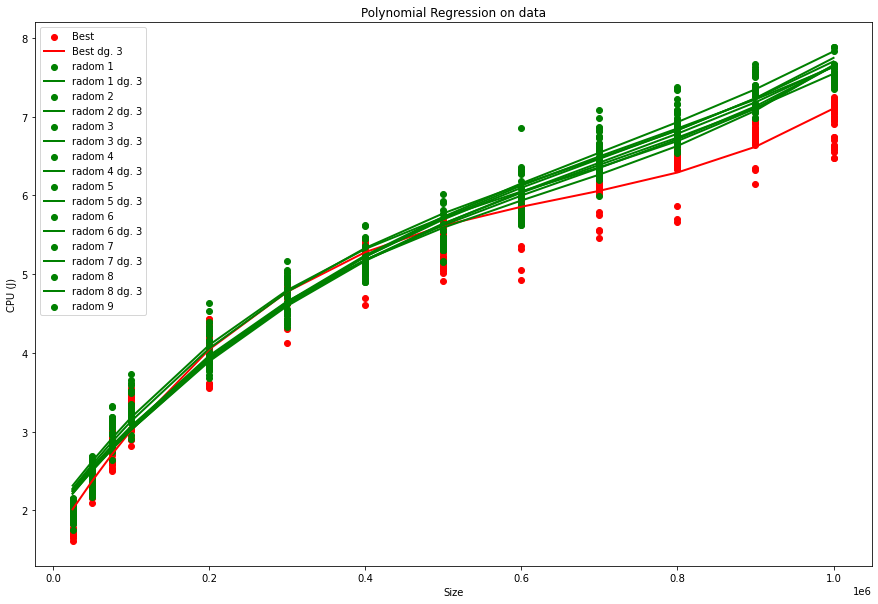

In [17]:
plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["CPU (J)"], 4, "Best", "red", minDegrees=3, printR2Score=False)

for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"], 4, f"radom {i}", "green", minDegrees=3, printR2Score=False)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('CPU (J)')
plt.show()

#### Best and Random case Time (ms) vs Size

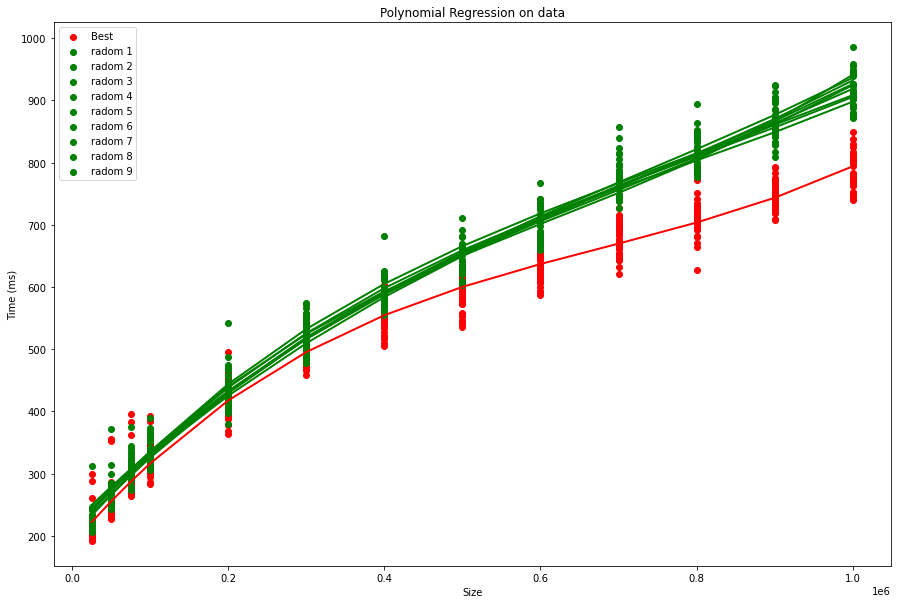

In [39]:
plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["Time (ms)"], 4, "Best", "red", minDegrees=3,printR2Score=False, plotLabel=False)

for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"], 4, f"radom {i}", "green",minDegrees=3,printR2Score=False, plotLabel=False)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.show()

#### Time (ms) and CPU (J) vs Size

r2_score for Best 1 is: 0.9764360958759256
r2_score for Best 2 is: 0.9818738698339248
r2_score for Best 3 is: 0.9824722252246518


r2_score for radom 1 1 is: 0.9894325390772891
r2_score for radom 1 2 is: 0.9899181668546567
r2_score for radom 1 3 is: 0.9915061088250762


r2_score for radom 2 1 is: 0.9883435102476292
r2_score for radom 2 2 is: 0.9909628227907196
r2_score for radom 2 3 is: 0.9927166954997511


r2_score for radom 3 1 is: 0.9814309452280978
r2_score for radom 3 2 is: 0.9866101908085931
r2_score for radom 3 3 is: 0.9886552647757403


r2_score for radom 4 1 is: 0.989117382260771
r2_score for radom 4 2 is: 0.9904645178347936
r2_score for radom 4 3 is: 0.9910984537862134


r2_score for radom 5 1 is: 0.9846514029481349
r2_score for radom 5 2 is: 0.985547755503673
r2_score for radom 5 3 is: 0.9875855891620511


r2_score for radom 6 1 is: 0.9910522297610632
r2_score for radom 6 2 is: 0.9918517751755026
r2_score for radom 6 3 is: 0.9935087338992482


r2_score for radom 7 1 is: 0.97

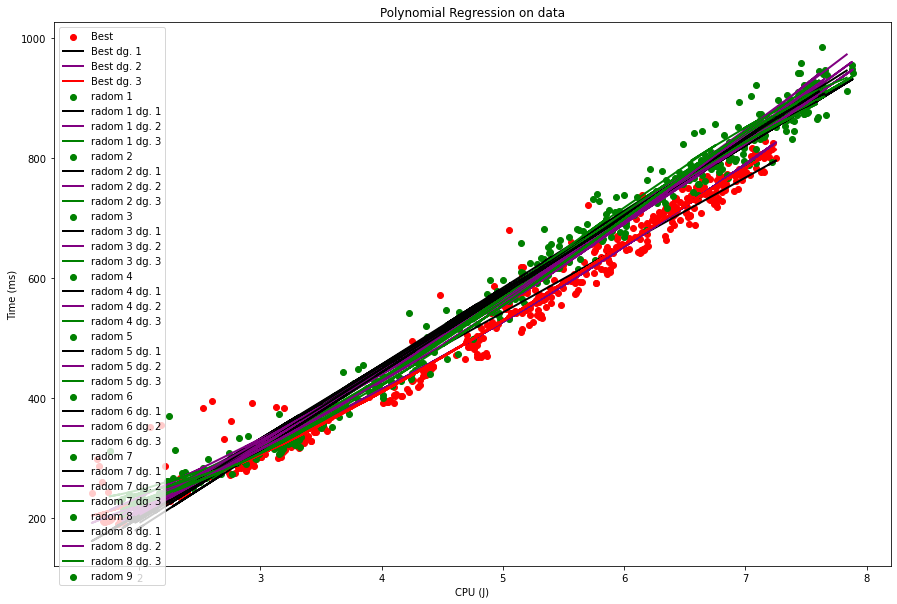

In [19]:
plt.figure(figsize=(15, 10))
polyReg(dfBest["CPU (J)"], dfBest["Time (ms)"], 4, "Best", "red", minDegrees=1,printR2Score=True)
print("\n")

for i in range(1,10):
    polyReg(listOfRandoms[i]["CPU (J)"], listOfRandoms[i]["Time (ms)"], 4, f"radom {i}", "green",minDegrees=1,printR2Score=True)
    print("\n")

plt.title('Polynomial Regression on data')
plt.xlabel('CPU (J)')
plt.ylabel('Time (ms)')
plt.show()

#### ALL cases CPU (J) vs Size

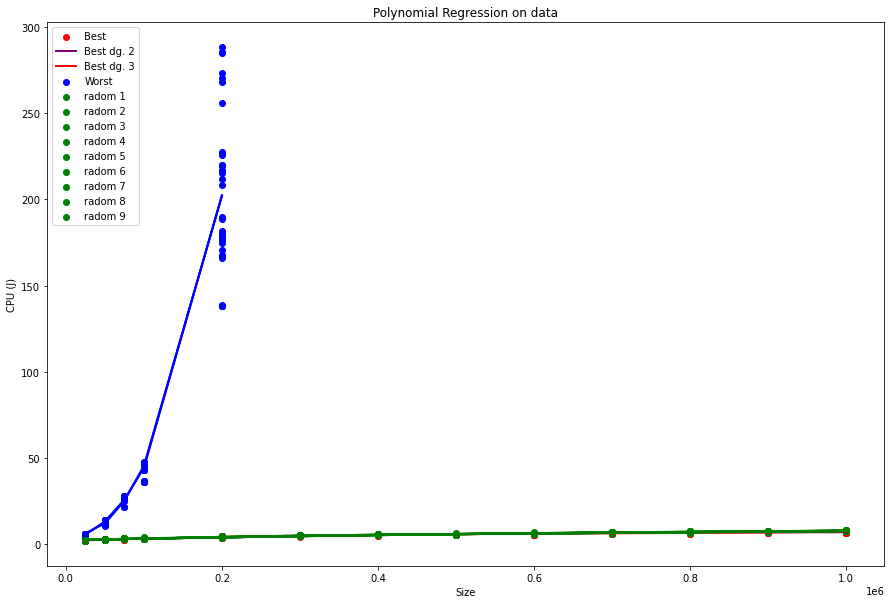

In [41]:
plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["CPU (J)"], 4, "Best", "red",printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["CPU (J)"], 5, "Worst", "blue",printR2Score=False, plotLabel=False)

for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["CPU (J)"], 4, f"radom {i}", "green",printR2Score=False, plotLabel=False)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('CPU (J)')
plt.show()

#### ALL cases Time (ms) vs Size

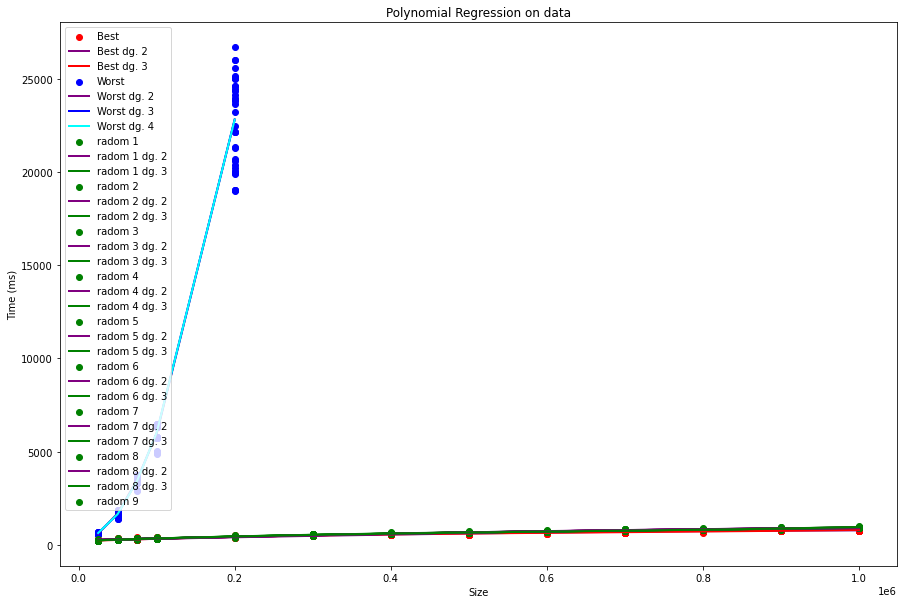

In [21]:
plt.figure(figsize=(15, 10))
polyReg(dfBest["Size"], dfBest["Time (ms)"], 4, "Best", "red",printR2Score=False)
polyReg(dfWorst["Size"], dfWorst["Time (ms)"], 5, "Worst", "blue",printR2Score=False)

for i in range(1,10):
    polyReg(listOfRandoms[i]["Size"], listOfRandoms[i]["Time (ms)"], 4, f"radom {i}", "green",printR2Score=False)
plt.title('Polynomial Regression on data')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.show()

Since Degree 2,3 and 5 are similar we consider this data to follow a second degree polynomial. Where the function it follows is: f(x) = SOMETHING LIKE {2x^2+3x+6}

### 4.2 Model Construction and Validation

[Construct the model and validate the model design if necessary.]

### 4.3 Model Application and Performance Evaluation

[Apply the model and evaluate its performance] {SPLIT DATASET INTO TRAINING(80%) AND VALIDATION(20%) AND DO SOME ML VALIDATION}

### 4.4 Visualize and Analyze Your Results/Findings from Data Modelling

[Here you may visualize the modeling results, and/or analyze/interprete its meanings.] {PLOT THE GRAPH}

## 5. Conclusion and Discussion

[Here you may draw your conclusion based on the previous sections, and discuss the pros and cons of the project, and propose something for future work.]